In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler, scale
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# 데이터 불러오기 / 데이터 정리

In [3]:
IT_nonfinance = pd.read_excel('./data/dongboo/비재무/IT_비재무_TOTAL_최종.xlsx')

In [4]:
IT_finance = pd.read_excel('./data/dongboo/IT_TOTAL_재무사항.xlsx')

In [5]:
# krx에서 가져온 자료
IT_stock = pd.read_excel('./data/dongboo/IT_주가_total_krx.xlsx')

# IT_stock = pd.read_excel('./data/dongboo/IT_TOTAL_주가.xlsx')
# Medicine_stock = pd.read_excel('./data/dongboo/제약_TOTAL_주가.xlsx')

In [6]:
IT_info = pd.merge(IT_finance,IT_nonfinance, how = 'left', on = ['회사명','거래소코드','회계년도'])

In [7]:
IT = pd.merge(IT_info, IT_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])

In [8]:
#del IT['주식매입선택권.1']

# 회사별로 분리

In [9]:
lg = IT[IT['회사명'] == 'LG이노텍(주)']
sdi = IT[IT['회사명'] == '삼성SDI(주)']
ssem = IT[IT['회사명'] == '삼성전기(주)']
hynix = IT[IT['회사명'] == '에스케이하이닉스(주)']

In [10]:
def classify(stock):
    
    # 회계년도 순으로 정렬 및 인덱스 초기화
    stock.sort_values('회계년도', ascending= True, inplace = True)
    
    stock.reset_index(drop = True, inplace = True)
    
    
    # 새로운 변수 추가
    
    stock['3개월후종가'] = stock['종가'][1:].reset_index(drop=True)
    
    stock['분기수익률'] = (stock['3개월후종가'] - stock['종가']) / stock['종가']
    
    stock['수익률상승하락'] = stock['분기수익률']
    
    for i in range(len(stock)):
        if stock['분기수익률'][i] < 0.005:
            stock['수익률상승하락'][i] = 0
        else:
            stock['수익률상승하락'][i] = 1
        
       
    return stock

In [11]:
classify(lg)
classify(sdi)
classify(ssem)
classify(hynix)

,회사명,거래소코드,회계년도,자산(*),자본(*),* 수권주식수,*주당 액면가액,* 발행한 주식총수(*),보통주,우선주,지배기업주주지분(*),자본금(*),보통주자본금,우선주자본금,신종자본증권,자본잉여금(*),주식발행초과금,배당건설이자,주식매입선택권,감자차익,보험차익,합병차익,자산수증이익,채무면제이익,자기주식처분이익,전환권대가,신주인수권대가,교환권대가,전환권재매입이익,기타자본잉여금,재평가적립금(2001년 이전),기타자본(*),자기주식,자기주식처분손실,주식할인발행차금,주식매입선택권.1,감자차손,파생상품평가이익,파생상품평가손실,전환권재매입손실,기타,기타포괄손익누계액(*),금융자산평가손익,매도가능금융자산평가손익,관계기업 등 기타포괄손익,환산 관련 외환차이 적립금(환율변동차이),해외사업장순투자위험회피 적립금,확정급여제도의 보험수리적 손익 적립금,현금흐름위험회피 적립금,주식기준보상 적립금,재평가잉여금,기타.1,이익잉여금(결손금)(*),* (지배)당기순손익,이익준비금,재무구조개선적립금,기업합리화적립금,기타법정적립금,재평가손익,보험수리적손익,기타이익잉여금,미처분이익잉여금(결손금),*전기이월미처분이익잉여금(결손금),비지배주주지분,* (비지배)당기순손익,*비지배주주지분초과손실액,부채(*),* (정상)영업손익(보고서기재),* (정상)영업손익(계산수치),기타이익(*),이자수익,배당금수익,외환거래이익(*),외환차익,외환환산이익,기타외화거래이익,보험차익.1,퇴직연금운용이익,전기오류수정이익,기타.2,기타손실(*),이자비용,외환거래손실(*),외환차손,외화환산손실,기타외환거래손실,법인세추납액,퇴직연금운용손실,전기오류수정손실,기타.3,법인세비용차감전순이익(손실),법인세비용,종속회사 매수일전 순손익,처분된 종속회사 순손익,계속영업이익(손실),중단영업이익(손실),*중단영업손익 법인세효과,당기순이익(손실),기타포괄손익(*),금융자산평가손익.1,매도가능금융자산평가손익.1,관계기업 등 기타포괄손익.1,환산 관련 외환차이(환율변동차이),해외사업장순투자위험회피,현금흐름위험회피 적립금.1,확정급여제도의 보험수리적손익,주식기준보상 적립금.1,재평가손익.1,기타.4,기타포괄손익관련 법인세,총포괄손익,*(당기순손익 귀속)지배기업주주지분,*계속영업손익,*중단영업손익,*(당기순손익 귀속)비지배주주지분,*계속영업손익.1,*중단영업손익.1,*(총포괄손익 귀속)지배기업주주지분,*(총포괄손익 귀속)비지배주주지분,*주당계속영업이익,*주당순손익,*희석주당계속영업이익,*희석주당순손익,*(지배기업주주지분)주당계속영업이익,*(지배기업주주지분)주당순손익,*(지배기업주주지분)희석주당계속영업이익,*(지배기업주주지분)희석주당순손익,* 성격별 비용계정(*),제품과 재공품의 변동,기업이 수행한 용역으로서 자본화되어 있는 부분,원재료와 저장품(소모품)의 사용액,상품의 판매,기타원가,종업원 급여비용,감가상각비와 기타상각비 및 손상차손,세금과공과,대손상각비,물류비(운송보관),광고 및 판매촉진비,임차료 및 리스료,경상연구개발비,기타비용,기말자본금(*),기초자본금,유상증자(감자),무상증자(감자),주식매수선택권,전환사채,신주인수권부사채,주식배당,합병분할(영업양수도 등)로 인한 변동,회계정책변경누적효과,오류수정 등,연결범위의 변동,외화환산차이,기타.5,기말신종자본증권(*),기초신종자본증권,신종자본증권의 발행,기타.6,기말자본잉여금(*),기초자본잉여금,유상증자(감자).1,무상증자(감자).1,주식발행초과금.1,주식매수선택권.1,감자차손익,보험차익.2,자기주식처분손익,전환권대가(전환사채),신주인수권대가(신주인수권부사채),교환권대가(교환사채),전환권재매입손익,결손금처리,지분법자본잉여금,합병분할(영업양수도 등)로 인한 변동.1,회계정책변경누적효과.1,오류수정 등.1,연결범위의 변동.1,외화환산차이.1,기타.7,기말기타자본(*),기초기타자본,자기주식.1,자기주식처분손실.1,주식할인발행차금.1,주식매입선택권.2,파생상품평가이익.1,파생상품평가손실.1,출자전환채무,신주청약증거금,감자차손익.1,전환권재매입손익.1,지분법자본조정,합병분할(영업양수도 등)로 인한 변동.2,회계정책변경누적효과.2,오류수정 등.2,연결범위의 변동.2,외화환산차이.2,기타.8,기말기타포괄손익누계액(*),기초기타포괄손익누계액,금융자산평가손익.2,매도가능금융자산 평가손익,관계기업 등 기타포괄손익.2,환산 관련 외환차이 적립금(환율변동차이).1,해외사업장순투자위험회피 적립금.1,확정급여제도의 보험수리적 손익 적립금.1,현금흐름위험회피 적립금.2,주식기준보상 적립금.2,재평가잉여금.1,합병분할(영업양수도 등)로 인한 변동.3,회계정책변경누적효과.3,오류수정 등.3,연결범위의 변동.3,외화환산차이.3,기타.9,기말이익잉여금(결손금)(*),처분후 이익잉여금(결손금)(*),수정후 이익잉여금(결손금)(*),기초이익잉여금(결손금),회계정책변경누적효과.4,전기오류수정손익,기타.10,(연차배당),(신종자본증권 분배금),주식할인발행차금의 상각,자기주식처분손실의 상각,결손금처리.1,기타이익잉여금처분액,(중간배당),기타포괄손익,당기순이익(총포괄손익),보험수리적손익.1,재평가손익.2,지분법이익잉여금,합병분할(영업양수도 등)로 인한 변동.4,연결범위의 변동.4,외화환산차이.4,기타.11,기말비지배주주지분(*),처분후 비지배주주지분(*),수정후 비지배주주지분(*),기초 비지배주주지분,회계정책변경누적효과.5,전기오류수정손익.1,기타.12,(종속회사의 배당금),기타.13,(중간배당).1,당기순이익(총포괄손익).1,재평가잉여금.2,금융자산평가손익.3,매도가능금융자산 평가손익.1,관계기업 등 지분법평가손익,환산 관련 외환차이 적립금(환율변동차이).2,해외사업장순투자위험회피 적립금.2,확정급여제도의 보험수리적 손익 적립금.2,현금흐름위험회피 적립금.3,주식기준보상 적립금.3,기타포괄손익누계액,합병분할로 인한 변동,연결범위의 변동.5,외화환산차이.5,기타.14,영업활동으로 인한 현금흐름(간접법)(*),*(직접법)총현금유입(*),재화의 판매와 용역제공에 따른 현금유입,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유입",이자수취액,배당금수취액,법인세환급,기타현금유입액,*(직접법)총현금유출(*),종업원과 관련하여 직·간접으로 발생하는 현금유출,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유출",이자비용유출액,배당금지급액,법인세납부,단기매매목적으로 보유하는 계약에서 발생하는 현금유출,기타현금유출액,당기순손익,법인세비용차감전순손익,현금 유출이 없는 비용 등 가산(*),전기오류수정손익.2,비지배주주지분순손익,보험수리적손실,기타.15,(현금 유입이 없는 수익 등 차감)(*),전기오류수정손익.3,비지배주주지분순손익.1,보험수리적이익,기타.16,영업활동으로 인한 자산부채 변동(운전자본 변동)(*),자산의 감소(증가)(*),부채의 증가(감소)(*),정부보조금 등의 변동,기타 운전자본의 변동,*영업에서 창출된 현금흐름,이자수입,이자지급(-),배당금수입,배당금지급(-),법인세환입,법인세납부(-),중단영업관련 현금흐름,투자활동으로 인한 현금흐름(*),투자활동으로 인한 현금유입액(*),정부보조금 등의 변동.1,종속기업 및 기타사업의 지배력 관련한 현금흐름,합병분할(양수도등)으로 인한 현금유입액,기타투자활동으로 인한 현금유입액,(투자활동으로 인한 현금유출액)(*),정부보조금 등의 변동.2,종속기업 및 기타사업의 지배력 관련한 현금흐름.1,합병분할(양수도등)으로 인한 현금유출액,기타투자활동으로 인한 현금유출액,이자수입.1,이자지급(-).1,배당금수입.1,배당금지급(-).1,법인세환입.1,법인세납부(-).1,중단영업관련 현금흐름.1,재무활동으로 인한 현금흐름(*),재무활동으로 인한 현금유입액(*),기타부채의 증가,유상증자,자본금의 증가,자본잉여금의 증가,종속회사의 증자 등,이익잉여금의 증가,자기주식의 처분,주식매입선택권의 행사,연결자본거래로인한현금유입액,종속기업 소유지분 변동에 따른 현금흐름,비지배주주지분의 증가,정부보조금 등의 변동.3,환율변동으로인한 차이조정,합병분할(양수도등)으로 인한 현금유입액.1,기타재무활동으로 인한 현금유입액,(재무활동으로 인한 현금유출액)(*),유상감자,자본금의 감소,자본잉여금의 감소,종속회사의 감자 등,이익잉여금의 감소,자기주식의 취득,연결자본거래로인한현금유출액,종속기업 소유지분 변동

In [12]:
lg = lg.iloc[:-1,:]
sdi = sdi.iloc[:-1,:]
ssem = ssem.iloc[:-1,:]
hynix = hynix.iloc[:-1,:]

# 산업별 변수 <3개월 후 종가>와의 상관관계 분석

In [13]:
# 밑에 함수로 해보기!!!!

In [14]:
lg_corr = lg.corr(method = 'pearson')
df_lg = pd.DataFrame(lg_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_lg.columns = ['지표','3개월후종가']

sdi_corr = sdi.corr(method = 'pearson')
df_sdi = pd.DataFrame(sdi_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_sdi.columns = ['지표','3개월후종가']

ssem_corr = ssem.corr(method = 'pearson')
df_ssem = pd.DataFrame(ssem_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_ssem.columns = ['지표','3개월후종가']

hynix_corr = hynix.corr(method = 'pearson')
df_hynix = pd.DataFrame(hynix_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hynix.columns = ['지표','3개월후종가']

# 산업별 상관관계 데이터프레임

In [15]:
pd.concat([df_lg.reset_index(drop = True), df_sdi.reset_index(drop = True), df_ssem.reset_index(drop = True), df_hynix.reset_index(drop = True)],axis = 1)

,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가
0,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000
1,최고가,0.767493,최고가,0.820795,최고가,0.827799,종가,0.948256
2,종가,0.747660,자기주식수(주),0.813923,종가,0.818502,최고가,0.947936
3,최저가,0.712841,종가,0.809146,최저가,0.801165,최저가,0.944148
4,거래대금,0.686572,최저가,0.781223,거래대금,0.730220,* (정상)영업손익(계산수치),0.930893
5,거래량,0.598758,회계정책변경누적효과.4,0.593481,해외사업장순투자위험회피 적립금,0.703484,* (정상)영업손익(보고서기재),0.928501
6,기말이익잉여금(결손금)(*),0.539389,정부보조금 등의 변동.1,0.580991,* (정상)영업손익(보고서기재),0.659242,법인세비용차감전순이익(손실),0.918030
7,이익잉여금(결손금)(*),0.539389,기간제_기말인원(명),0.480034,* (정상)영업손익(계산수치),0.655114,*(지배기업주주지분)주당순손익,0.915234
8,*(당기순손익 귀속)지배기업주주지분,0.517290,미처분이익잉여금(결손금),0.474870,거래량,0.593055,*(지배기업주주지분)주당계속영업이익,0.915234
9,당기순이익(손실),0.517248,매도가능금융자산 평가손익.1,0.461993,기초자본잉여금,0.545441,*(당기순손익 귀속)지배기업주주지분,0.914956


In [16]:
list_corr = []
order = 30 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_lg.index[:order])):
    list_corr.append(df_lg.index[:order][i])
    list_corr.append(df_sdi.index[:order][i])
    list_corr.append(df_ssem.index[:order][i])
    list_corr.append(df_hynix.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

In [17]:
var = []
for i in range(len(variable)):
    var.append(df_lg[df_lg.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

In [18]:
corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]

# 3개월후 종가 및 수익률 상승하락  drop 시킴

In [19]:
corr = corr[corr['var'] != '3개월후종가'].reset_index(drop = True)
corr = corr[corr['var'] != '수익률상승하락'].reset_index(drop = True)
corr

,var_index,var,number
0,59,미처분이익잉여금(결손금),4
1,388,종가,4
2,66,* (정상)영업손익(계산수치),4
3,387,최저가,4
4,386,최고가,4
5,65,* (정상)영업손익(보고서기재),3
6,390,거래대금,3
7,92,계속영업이익(손실),3
8,88,법인세비용차감전순이익(손실),3
9,108,총포괄손익,3


# 위 자료를 보고 변수 선정

In [20]:
deep_lg = lg[corr['var'][:20]]
deep_sdi = sdi[corr['var'][:20]]
deep_ssem = ssem[corr['var'][:20]]
deep_hynix = hynix[corr['var'][:20]]

# deep_lg = lg[corr['var'][:45]]
# deep_sdi = sdi[corr['var'][:45]]
# deep_ssem = ssem[corr['var'][:45]]
# deep_hynix = hynix[corr['var'][:45]]


deep_lg['수익률상승하락'] = lg['수익률상승하락']
deep_sdi['수익률상승하락'] = sdi['수익률상승하락']
deep_ssem['수익률상승하락'] = ssem['수익률상승하락']
deep_hynix['수익률상승하락'] = hynix['수익률상승하락']

In [21]:
deep_sdi

,미처분이익잉여금(결손금),종가,* (정상)영업손익(계산수치),최저가,최고가,* (정상)영업손익(보고서기재),거래대금,계속영업이익(손실),법인세비용차감전순이익(손실),총포괄손익,당기순이익(손실),매도가능금융자산 평가손익,이익잉여금(결손금)(*),* (지배)당기순손익,해외사업장순투자위험회피 적립금,기말이익잉여금(결손금)(*),법인세비용,이자지급(-),이익준비금,분기수익률,수익률상승하락
0,177410565,137750,35045876,129500,146000,64656618,1117298042500,56006982,63912711,90474300,56006983,60314277,3024403565,46696585,0,3024403565,7905729,-6494083,101265000,0.266788,1.0
1,245832871,174500,48192963,167000,182000,83647666,2495911626000,78221512,98805464,251112821,78221511,181151985,3092825871,115118891,0,3092825871,20583952,-12564164,0,-0.057307,0.0
2,415666024,164500,121854634,154500,174500,123809638,1843565266625,167510191,182507486,364994020,167510190,412224658,3262659024,274778141,0,3262659024,14997295,-21487631,0,0.037994,1.0
3,544059037,170750,29130355,162500,179000,14698275,1779554946000,83373657,77374652,399720684,83373658,745637031,3391052037,356102770,-26219967,3391052037,-5999005,-25343521,0,-0.029283,0.0
4,324009540,165750,8595066,157000,174500,60347343,2146377902500,83464922,111688509,27120354,83464922,-43725890,3398102540,78712662,-35407726,3398102540,28223588,-3911251,0,0.010558,1.0
5,410522537,167500,55546053,156500,178500,89228461,1898624931500,94821566,130549033,194849971,94821566,78528197,3484615537,165225659,-44840784,3484615537,35727468,-7776689,0,-0.289552,0.0
6,510479176,119000,27992220,100000,138000,43010471,1461671086500,111570831,135887011,-18312288,111570831,-133970357,3584572176,265182298,10576243,3584572176,24316180,-14814067,0,0.176471,1.0
7,536711370,140000,17834633,130500,149500,11127476,1151550699000,61197597,99974960,-46708398,61197597,-202095007,3610804370,320109230,-14982169,3610804370,38777364,-18107543,0,0.007143,1.0
8,721988414,141000,16869079,136000,146000,67037476,988248477000,118809346,165202801,246599051,118809346,130970928,3655481414,112010791,-16437483,3655481414,46393455,-5672316,0,0.081560,1.0
9,827317792,152500,82628588,148000,157000,83970453,657899482000,116147767,166302103,-65347267,116147767,-45392373,3760810792,217340169,-22083849,3760810792,50154335,-10517902,0,-0.006557,0.0


In [22]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_lg = StandardScaler()
scale_lg = pd.DataFrame(scaler_lg.fit_transform(deep_lg.iloc[:,:-1]))

scaler_sdi = StandardScaler()
scale_sdi = pd.DataFrame(scaler_sdi.fit_transform(deep_sdi.iloc[:,:-1]))

scaler_ssem = StandardScaler()
scale_ssem = pd.DataFrame(scaler_ssem.fit_transform(deep_ssem.iloc[:,:-1]))

scaler_hynix = StandardScaler()
scale_hynix = pd.DataFrame(scaler_hynix.fit_transform(deep_hynix.iloc[:,:-1]))

# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [23]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT = pd.concat([scale_lg,scale_sdi,scale_ssem,scale_hynix], ignore_index=True)

scale_IT

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.431253,0.203218,0.086506,-0.088766,0.440716,0.117219,0.633011,0.844959,0.577988,0.623991,0.878315,-0.146684,-0.727987,0.163307,0.494997,-0.727987,-0.325976,1.051379,-1.282872,2.135468
1,0.296818,2.056259,1.025009,2.233115,1.886832,1.165526,1.878677,0.738136,1.061075,2.093125,2.249426,2.513563,0.161044,1.497919,0.494997,0.161044,1.443321,0.644343,-1.282872,-0.876157
2,0.738900,1.158468,0.747990,1.283794,1.041910,0.606023,2.411078,1.539851,0.995086,0.884958,1.366400,2.506434,0.700861,2.376040,0.494997,0.700861,-0.775009,0.054291,-1.282872,-0.416760
3,-2.341078,0.862197,-1.833499,1.086019,0.668195,-1.728976,0.310820,-0.842527,-1.557092,-0.736206,-0.822966,2.502017,0.480619,2.116945,0.494997,0.480619,-2.722385,-0.622881,-1.282872,-0.585839
4,0.434428,0.422279,-1.147154,0.472916,0.375722,-1.054652,0.473221,-0.556316,-0.925656,-0.551531,-0.566171,-0.148084,0.335272,-0.587624,0.494997,0.335272,-1.479143,0.840896,-0.572198,-1.067482
5,0.384303,-0.392916,-0.696006,-0.270719,-0.488697,-0.741847,-0.882683,-0.486162,-0.670882,-0.452355,-0.501348,-0.147155,0.274067,-0.679585,0.494997,0.274067,-0.863685,-0.070652,-0.572198,-1.823000
6,0.128138,-1.581591,-1.319735,-1.734256,-1.437609,-1.007500,-0.854168,-1.270868,-1.294826,-0.526163,-1.226416,-3.784102,-0.038733,-1.148344,0.494997,-0.038733,-0.831815,-1.040917,-0.572198,0.410715
7,-0.603596,-1.335597,-1.615512,-1.287284,-1.359616,-2.294374,-0.905230,-2.856991,-2.315352,-2.401617,-2.691990,-0.161057,-0.932238,-2.378557,0.494997,-0.932238,-0.019650,-2.089645,-0.572198,2.004433
8,-0.620758,-0.251065,-0.484390,-0.239075,-0.257969,-0.319186,0.067875,-0.361412,-0.332730,-0.361867,-0.386079,-0.138740,-0.953198,-0.494046,0.494997,-0.953198,-0.126265,0.567259,-0.572198,-1.019123
9,-0.588698,-0.902861,-0.558274,-1.057865,-0.764921,-0.432598,-0.939020,-0.172177,-0.510462,-0.124243,-0.211227,-0.138740,-0.914054,-0.435249,0.494997,-0.914054,-1.153721,-0.486275,-0.572198,0.077338


In [24]:
scale_IT.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,0.510372,0.439645,0.506436,0.509078,0.350835,0.367120,0.518700,0.532994,0.497917,0.495218,0.056622,0.500779,0.537493,0.021597,0.500779,0.505834,0.304228,0.436030,0.087465
1,0.510372,1.000000,0.648414,0.993750,0.995259,0.568545,0.727642,0.495889,0.483912,0.512629,0.490866,0.322390,0.307627,0.554983,0.210016,0.307627,0.372693,0.365115,0.117444,-0.209250
2,0.439645,0.648414,1.000000,0.638789,0.651119,0.845863,0.470840,0.746909,0.760463,0.702472,0.702459,0.161985,0.203370,0.583240,0.210734,0.203370,0.650885,0.158281,0.128793,-0.039360
3,0.506436,0.993750,0.638789,1.000000,0.978205,0.557744,0.695918,0.486982,0.475371,0.502037,0.484442,0.349550,0.300661,0.570470,0.210678,0.300661,0.367587,0.359524,0.108737,-0.232622
4,0.509078,0.995259,0.651119,0.978205,1.000000,0.573642,0.748313,0.499426,0.487338,0.517485,0.492666,0.295218,0.311230,0.536574,0.207552,0.311230,0.374615,0.365303,0.124590,-0.186607
5,0.350835,0.568545,0.845863,0.557744,0.573642,1.000000,0.443719,0.760330,0.787203,0.728893,0.730125,0.119424,0.175808,0.495816,0.165453,0.175808,0.721767,0.192385,0.055742,-0.026541
6,0.367120,0.727642,0.470840,0.695918,0.748313,0.443719,1.000000,0.356791,0.341769,0.396839,0.370594,0.214918,0.066161,0.342472,0.224975,0.066161,0.235129,0.286663,0.039603,-0.151284
7,0.518700,0.495889,0.746909,0.486982,0.499426,0.760330,0.356791,1.000000,0.985181,0.870804,0.935808,0.120797,0.295781,0.703916,0.070847,0.295781,0.783471,0.235225,0.140099,0.063447
8,0.532994,0.483912,0.760463,0.475371,0.487338,0.787203,0.341769,0.985181,1.000000,0.862984,0.929948,0.095105,0.292704,0.683123,0.058144,0.292704,0.874840,0.212629,0.154437,0.087325
9,0.497917,0.512629,0.702472,0.502037,0.517485,0.728893,0.396839,0.870804,0.862984,1.000000,0.917226,0.248854,0.241614,0.648251,0.068850,0.241614,0.695544,0.241457,0.142152,0.036595


In [25]:
# data = list_company3[1].loc[:,['순자산(백만원)', '판매비와 관리비(물류원가 등 포함)(백만원)',
#        '법인세비용차감전순이익(백만원)', '법인세비용(백만원)', '계속영업이익(손실)(백만원)',
#         '당기순이익(백만원)', '기타포괄손익(백만원)', '총포괄손익(백만원)', '배당금(백만원)', '3개월뒤종가(원)']]
# data

In [26]:
# # 표준화

# from sklearn.preprocessing import StandardScaler

# #scaler_lg = StandardScaler()
# #scale_lg = pd.DataFrame(scaler_lg.fit_transform(deep_lg.iloc[:,:-1]))


# # IT 업종 표준화

# scaler_IT = StandardScaler()
# scale_lg = pd.DataFrame(scaler_IT.fit_transform(clean_lg))
# scale_hynix = pd.DataFrame(scaler_IT.fit_transform(clean_hynix))
# scale_ssem = pd.DataFrame(scaler_IT.fit_transform(clean_ssem))
# scale_sdi = pd.DataFrame(scaler_IT.fit_transform(clean_sdi))

In [27]:
# #deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# # 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
# deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# # 표준화한 변수를 합치려고 만듬
# scale_IT = pd.concat([scale_lg,scale_sdi,scale_ssem,scale_hynix], ignore_index=True)

In [28]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import matplotlib
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

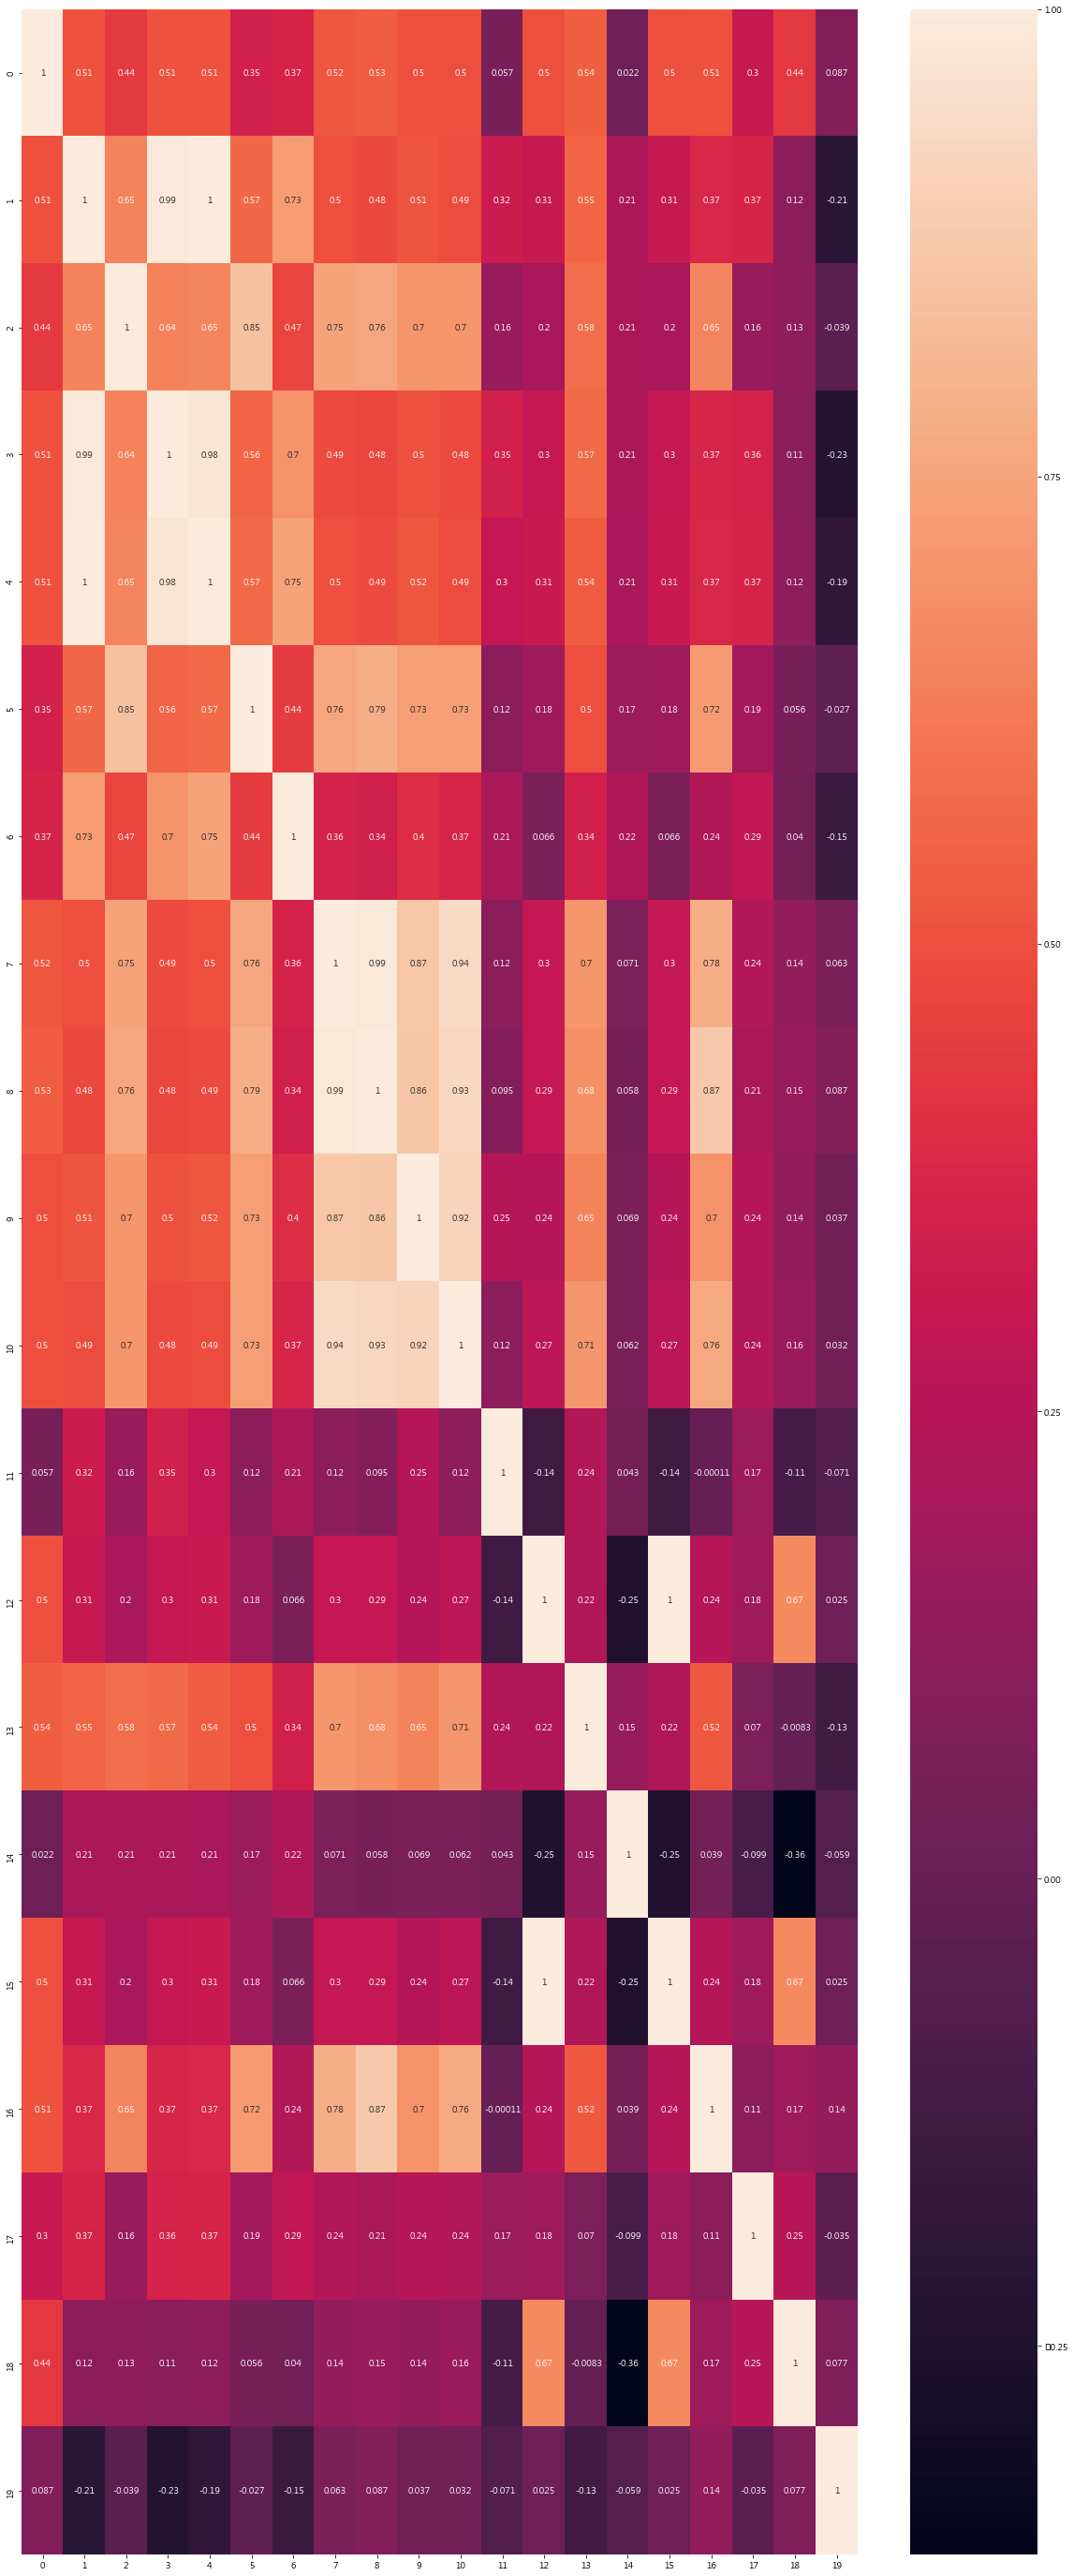

In [29]:
plt.figure(figsize=(20,50))

sns.heatmap(data = scale_IT.corr(), annot = True)
# plt.savefig('tmp.png')

In [30]:
# deep_IT = deep_IT.drop(['발행할 주식의 총수(주)', '현재까지 발행한 주식의 총수(주)', '현재까지 감소한 주식의 총수(주)',
#                         '정규+무기계약_기말인원(남)(명)', '정규+무기계약_기말인원(여)(명)', '기간제_기말인원(남)(명)',
#                         '합계_기말인원_남(명)', '합계_기말인원_여(명)'], axis = 1)
# deep_IT = deep_IT.drop('합계_기말인원(명)', axis = 1)

In [31]:
#scale_IT = scale_IT.drop([2,4],axis = 1)

In [32]:
scale_IT.head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.431253,0.203218,0.086506,-0.088766,0.440716,0.117219,0.633011,0.844959,0.577988,0.623991,0.878315,-0.146684,-0.727987,0.163307,0.494997,-0.727987,-0.325976,1.051379,-1.282872,2.135468
1,0.296818,2.056259,1.025009,2.233115,1.886832,1.165526,1.878677,0.738136,1.061075,2.093125,2.249426,2.513563,0.161044,1.497919,0.494997,0.161044,1.443321,0.644343,-1.282872,-0.876157
2,0.738900,1.158468,0.747990,1.283794,1.041910,0.606023,2.411078,1.539851,0.995086,0.884958,1.366400,2.506434,0.700861,2.376040,0.494997,0.700861,-0.775009,0.054291,-1.282872,-0.416760
3,-2.341078,0.862197,-1.833499,1.086019,0.668195,-1.728976,0.310820,-0.842527,-1.557092,-0.736206,-0.822966,2.502017,0.480619,2.116945,0.494997,0.480619,-2.722385,-0.622881,-1.282872,-0.585839
4,0.434428,0.422279,-1.147154,0.472916,0.375722,-1.054652,0.473221,-0.556316,-0.925656,-0.551531,-0.566171,-0.148084,0.335272,-0.587624,0.494997,0.335272,-1.479143,0.840896,-0.572198,-1.067482


In [33]:
#deep_IT.columns

In [34]:
scale_IT

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.431253,0.203218,0.086506,-0.088766,0.440716,0.117219,0.633011,0.844959,0.577988,0.623991,0.878315,-0.146684,-0.727987,0.163307,0.494997,-0.727987,-0.325976,1.051379,-1.282872,2.135468
1,0.296818,2.056259,1.025009,2.233115,1.886832,1.165526,1.878677,0.738136,1.061075,2.093125,2.249426,2.513563,0.161044,1.497919,0.494997,0.161044,1.443321,0.644343,-1.282872,-0.876157
2,0.738900,1.158468,0.747990,1.283794,1.041910,0.606023,2.411078,1.539851,0.995086,0.884958,1.366400,2.506434,0.700861,2.376040,0.494997,0.700861,-0.775009,0.054291,-1.282872,-0.416760
3,-2.341078,0.862197,-1.833499,1.086019,0.668195,-1.728976,0.310820,-0.842527,-1.557092,-0.736206,-0.822966,2.502017,0.480619,2.116945,0.494997,0.480619,-2.722385,-0.622881,-1.282872,-0.585839
4,0.434428,0.422279,-1.147154,0.472916,0.375722,-1.054652,0.473221,-0.556316,-0.925656,-0.551531,-0.566171,-0.148084,0.335272,-0.587624,0.494997,0.335272,-1.479143,0.840896,-0.572198,-1.067482
5,0.384303,-0.392916,-0.696006,-0.270719,-0.488697,-0.741847,-0.882683,-0.486162,-0.670882,-0.452355,-0.501348,-0.147155,0.274067,-0.679585,0.494997,0.274067,-0.863685,-0.070652,-0.572198,-1.823000
6,0.128138,-1.581591,-1.319735,-1.734256,-1.437609,-1.007500,-0.854168,-1.270868,-1.294826,-0.526163,-1.226416,-3.784102,-0.038733,-1.148344,0.494997,-0.038733,-0.831815,-1.040917,-0.572198,0.410715
7,-0.603596,-1.335597,-1.615512,-1.287284,-1.359616,-2.294374,-0.905230,-2.856991,-2.315352,-2.401617,-2.691990,-0.161057,-0.932238,-2.378557,0.494997,-0.932238,-0.019650,-2.089645,-0.572198,2.004433
8,-0.620758,-0.251065,-0.484390,-0.239075,-0.257969,-0.319186,0.067875,-0.361412,-0.332730,-0.361867,-0.386079,-0.138740,-0.953198,-0.494046,0.494997,-0.953198,-0.126265,0.567259,-0.572198,-1.019123
9,-0.588698,-0.902861,-0.558274,-1.057865,-0.764921,-0.432598,-0.939020,-0.172177,-0.510462,-0.124243,-0.211227,-0.138740,-0.914054,-0.435249,0.494997,-0.914054,-1.153721,-0.486275,-0.572198,0.077338


# 샤비어함수 및 히든레이어 5개

# 및 Validation

In [35]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_IT.iloc[:,:-1]
y_data = deep_IT.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.0001




X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([32]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# hypothesis = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer

# Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [41]:
# Launch graph

validation_number = 20
#init_state = lstm_cell.zero_state(128, tf.float32)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(200001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})
            print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    

    # Accuracy report
    h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

Step : 0 	 Cost : 1.1457633972167969 	 Acc : 40.00000059604645
Step : 1 	 Cost : 1.0143765211105347 	 Acc : 40.00000059604645
Step : 2 	 Cost : 0.9733170866966248 	 Acc : 40.00000059604645
Step : 3 	 Cost : 0.9384680986404419 	 Acc : 40.00000059604645
Step : 4 	 Cost : 0.9549544453620911 	 Acc : 40.00000059604645
Step : 5 	 Cost : 0.8459807634353638 	 Acc : 40.00000059604645
Step : 6 	 Cost : 0.9155212044715881 	 Acc : 40.00000059604645
Step : 7 	 Cost : 0.9669942855834961 	 Acc : 40.00000059604645
Step : 8 	 Cost : 0.9558340907096863 	 Acc : 40.00000059604645
Step : 9 	 Cost : 0.9345178604125977 	 Acc : 40.00000059604645
Step : 200 	 Cost : 0.8807569146156311 	 Acc : 40.00000059604645
Step : 400 	 Cost : 0.751501202583313 	 Acc : 40.00000059604645
Step : 600 	 Cost : 0.776608943939209 	 Acc : 40.00000059604645
Step : 800 	 Cost : 0.8560501933097839 	 Acc : 34.99999940395355
Step : 1000 	 Cost : 0.7431144118309021 	 Acc : 30.000001192092896
Step : 1200 	 Cost : 0.8554764986038208 	 Acc

Step : 47400 	 Cost : 0.6689280271530151 	 Acc : 40.00000059604645
Step : 47600 	 Cost : 0.7032846212387085 	 Acc : 40.00000059604645
Step : 47800 	 Cost : 0.6942980885505676 	 Acc : 40.00000059604645
Step : 48000 	 Cost : 0.6903455853462219 	 Acc : 40.00000059604645
Step : 48200 	 Cost : 0.6658695340156555 	 Acc : 40.00000059604645
Step : 48400 	 Cost : 0.7003134489059448 	 Acc : 40.00000059604645
Step : 48600 	 Cost : 0.6699445843696594 	 Acc : 40.00000059604645
Step : 48800 	 Cost : 0.7047402262687683 	 Acc : 40.00000059604645
Step : 49000 	 Cost : 0.6864414811134338 	 Acc : 40.00000059604645
Step : 49200 	 Cost : 0.6829911470413208 	 Acc : 40.00000059604645
Step : 49400 	 Cost : 0.6704226732254028 	 Acc : 40.00000059604645
Step : 49600 	 Cost : 0.6861248016357422 	 Acc : 40.00000059604645
Step : 49800 	 Cost : 0.6412884593009949 	 Acc : 40.00000059604645
Step : 50000 	 Cost : 0.6691874861717224 	 Acc : 40.00000059604645
Step : 50200 	 Cost : 0.6592530012130737 	 Acc : 40.0000005960

Step : 96200 	 Cost : 0.6662442088127136 	 Acc : 40.00000059604645
Step : 96400 	 Cost : 0.6735585331916809 	 Acc : 40.00000059604645
Step : 96600 	 Cost : 0.6357574462890625 	 Acc : 40.00000059604645
Step : 96800 	 Cost : 0.6638917326927185 	 Acc : 40.00000059604645
Step : 97000 	 Cost : 0.6624351739883423 	 Acc : 40.00000059604645
Step : 97200 	 Cost : 0.6627964377403259 	 Acc : 40.00000059604645
Step : 97400 	 Cost : 0.6644115447998047 	 Acc : 40.00000059604645
Step : 97600 	 Cost : 0.6790961027145386 	 Acc : 40.00000059604645
Step : 97800 	 Cost : 0.6623818278312683 	 Acc : 40.00000059604645
Step : 98000 	 Cost : 0.6713141202926636 	 Acc : 40.00000059604645
Step : 98200 	 Cost : 0.6516743898391724 	 Acc : 40.00000059604645
Step : 98400 	 Cost : 0.691405713558197 	 Acc : 40.00000059604645
Step : 98600 	 Cost : 0.6577228903770447 	 Acc : 40.00000059604645
Step : 98800 	 Cost : 0.6825678944587708 	 Acc : 40.00000059604645
Step : 99000 	 Cost : 0.6756815910339355 	 Acc : 40.00000059604

Step : 120400 	 Cost : 0.6495981216430664 	 Acc : 40.00000059604645
Step : 120600 	 Cost : 0.6698752641677856 	 Acc : 40.00000059604645
Step : 120800 	 Cost : 0.6706118583679199 	 Acc : 40.00000059604645
Step : 121000 	 Cost : 0.6669893860816956 	 Acc : 40.00000059604645
Step : 121200 	 Cost : 0.6843196749687195 	 Acc : 40.00000059604645
Step : 121400 	 Cost : 0.6498095393180847 	 Acc : 40.00000059604645
Step : 121600 	 Cost : 0.6572974324226379 	 Acc : 40.00000059604645
Step : 121800 	 Cost : 0.678111732006073 	 Acc : 40.00000059604645
Step : 122000 	 Cost : 0.623805820941925 	 Acc : 40.00000059604645
Step : 122200 	 Cost : 0.6875427961349487 	 Acc : 40.00000059604645
Step : 122400 	 Cost : 0.6626766920089722 	 Acc : 40.00000059604645
Step : 122600 	 Cost : 0.6828215718269348 	 Acc : 40.00000059604645
Step : 122800 	 Cost : 0.6810159683227539 	 Acc : 40.00000059604645
Step : 123000 	 Cost : 0.654133141040802 	 Acc : 40.00000059604645
Step : 123200 	 Cost : 0.6473137736320496 	 Acc : 4

Step : 168400 	 Cost : 0.6305723190307617 	 Acc : 40.00000059604645
Step : 168600 	 Cost : 0.6379505395889282 	 Acc : 40.00000059604645
Step : 168800 	 Cost : 0.6353893876075745 	 Acc : 40.00000059604645
Step : 169000 	 Cost : 0.6416775584220886 	 Acc : 40.00000059604645
Step : 169200 	 Cost : 0.6433177590370178 	 Acc : 40.00000059604645
Step : 169400 	 Cost : 0.6548442840576172 	 Acc : 40.00000059604645
Step : 169600 	 Cost : 0.6534550786018372 	 Acc : 40.00000059604645
Step : 169800 	 Cost : 0.6336185336112976 	 Acc : 40.00000059604645
Step : 170000 	 Cost : 0.6401171088218689 	 Acc : 40.00000059604645
Step : 170200 	 Cost : 0.648151695728302 	 Acc : 44.999998807907104
Step : 170400 	 Cost : 0.6330754160881042 	 Acc : 44.999998807907104
Step : 170600 	 Cost : 0.6402872800827026 	 Acc : 44.999998807907104
Step : 170800 	 Cost : 0.6297503709793091 	 Acc : 44.999998807907104
Step : 171000 	 Cost : 0.6384593844413757 	 Acc : 44.999998807907104
Step : 171200 	 Cost : 0.6246804594993591 	 

In [37]:
print('모델 정확도: ', a * 100 , '%')

모델 정확도:  60.00000238418579 %


In [38]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_data.iloc[-validation_number:,:].values.ravel()),'predict': list(c.ravel())})

,real,predict
0,0.0,1.0
1,1.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [39]:
h # hypothesis

array([[0.5238093 ],
       [0.53580993],
       [0.53473616],
       [0.537918  ],
       [0.52060944],
       [0.5235097 ],
       [0.529617  ],
       [0.5199462 ],
       [0.5050121 ],
       [0.5223279 ],
       [0.5155847 ],
       [0.48087525],
       [0.5181446 ],
       [0.52979004],
       [0.6466266 ]], dtype=float32)

# <span style="color:red"> 다른 주식으로 Validation
## 1) 5번째 가치주인 삼성전자를 대상으로 주가예측
## 2) 하락하는 주식을 대상으로 변수 분석 및 주가예측